In [28]:
from datasets import load_dataset, DatasetDict, Dataset

# Load the dataset
dataset = load_dataset("csv", data_files="archive/file.csv")["train"]

# Select the first 2000 rows
subset = dataset.select(range(1000))

# Display the subset
print(subset)

Dataset({
    features: ['Unnamed: 0', 'tweets', 'labels'],
    num_rows: 1000
})


In [29]:
dataset = DatasetDict({"train": subset})

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'tweets', 'labels'],
        num_rows: 1000
    })
})

In [31]:
df = dataset["train"].to_pandas()
df["labels"].unique()

array(['neutral', 'good', 'bad'], dtype=object)

In [32]:
df

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...,...
995,995,Top story: @GuyP: 'OK so @OpenAI's new #ChatGP...,neutral
996,996,Conspiracy theory: chatGPT is GPT4 being beta ...,bad
997,997,chatgpt 🫡 https://t.co/WJkkjKDcAa https://t.co...,bad
998,998,Writing React components with ChatGPT and Tail...,bad


In [33]:
df = df.drop(columns=['Unnamed: 0'])
df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
995,Top story: @GuyP: 'OK so @OpenAI's new #ChatGP...,neutral
996,Conspiracy theory: chatGPT is GPT4 being beta ...,bad
997,chatgpt 🫡 https://t.co/WJkkjKDcAa https://t.co...,bad
998,Writing React components with ChatGPT and Tail...,bad


In [34]:
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(df)
dataset

DatasetDict({
    train: Dataset({
        features: ['tweets', 'labels'],
        num_rows: 1000
    })
})

In [35]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

labels = encoder.fit_transform(dataset["train"]["labels"])

In [36]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("labels")
dataset = dataset.rename_column("tweets", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

In [37]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
})

In [44]:
checkpoint = "google-bert/bert-base-cased"

In [45]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

D:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\spase\.cache\huggingface\hub\models--google-bert--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [46]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [47]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3411.50 examples/s]


In [48]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=1,
    learning_rate=0.001,
    # report_to="none",
)

In [49]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [52]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [53]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [54]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.100187,0.096426


TrainOutput(global_step=50, training_loss=1.1317253112792969, metrics={'train_runtime': 1231.5681, 'train_samples_per_second': 0.65, 'train_steps_per_second': 0.041, 'total_flos': 39730126076928.0, 'train_loss': 1.1317253112792969, 'epoch': 1.0})

In [58]:
trainer.evaluate()

{'eval_loss': 1.1001869440078735,
 'eval_f1': 0.09642570281124499,
 'eval_runtime': 57.674,
 'eval_samples_per_second': 3.468,
 'eval_steps_per_second': 0.225,
 'epoch': 1.0}

In [59]:
predictions = trainer.predict(tokenized_dataset["test"])

In [60]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.00      0.00      0.00        61
           2       0.24      1.00      0.39        49

    accuracy                           0.24       200
   macro avg       0.08      0.33      0.13       200
weighted avg       0.06      0.24      0.10       200



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Confusion Matrix')

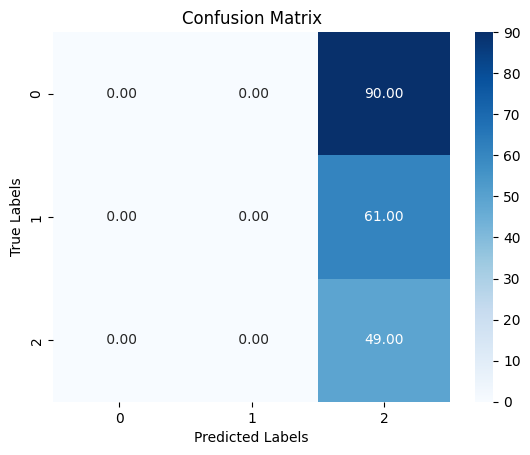

In [63]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [95]:

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [96]:
df = pd.read_csv("archive/file.csv")
df

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...,...
219289,219289,Other Software Projects Are Now Trying to Repl...,bad
219290,219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,219291,chatgpt is being disassembled until it can onl...,bad
219292,219292,2023 predictions by #chatGPT. Nothing really s...,bad


In [97]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [98]:
df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by #chatGPT. Nothing really s...,bad


In [102]:
df = df[:1000]

In [103]:
df

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
995,Top story: @GuyP: 'OK so @OpenAI's new #ChatGP...,neutral
996,Conspiracy theory: chatGPT is GPT4 being beta ...,bad
997,chatgpt 🫡 https://t.co/WJkkjKDcAa https://t.co...,bad
998,Writing React components with ChatGPT and Tail...,bad


<Axes: xlabel='labels'>

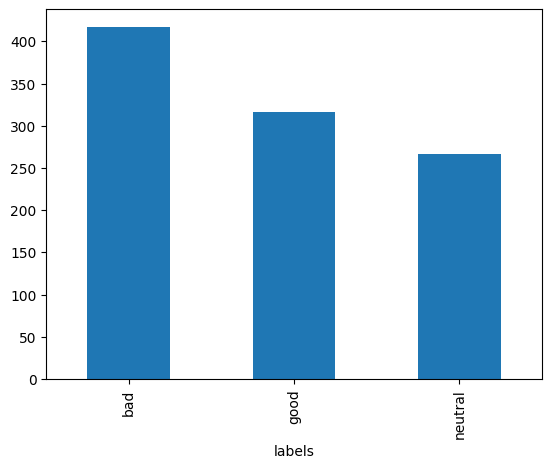

In [104]:
df["labels"].value_counts().plot.bar()

In [105]:
df.isnull().sum()

tweets    0
labels    0
dtype: int64

<Axes: ylabel='Frequency'>

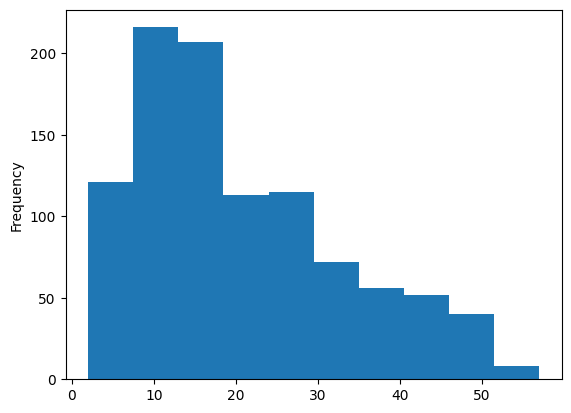

In [106]:
df["tweets"].str.split(" ").apply(len).plot.hist()

<Axes: >

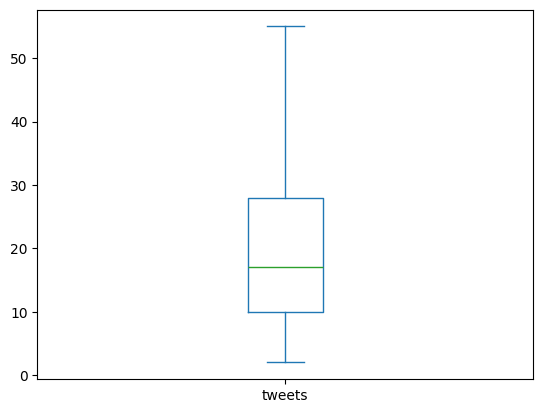

In [107]:
df["tweets"].str.split().apply(len).plot.box()

<Axes: ylabel='Frequency'>

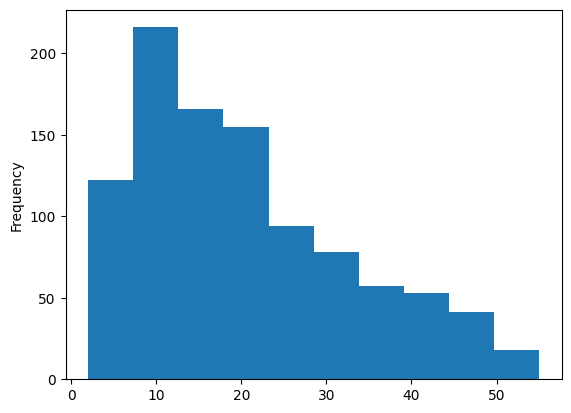

In [108]:
df["tweets"].str.split().apply(len).plot.hist()

In [109]:
def get_vocabulary(texts: list[str]) -> list[str]:
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [110]:
vocabulary = get_vocabulary(df["tweets"].tolist())

In [111]:
len(vocabulary)

6322

In [112]:
max_vocabulary_size = 6000

In [113]:
X, y = df["tweets"], pd.get_dummies(df["labels"])

In [114]:
y.head()

,bad,good,neutral
0,False,False,True
1,False,True,False
2,False,False,True
3,False,True,False
4,True,False,False


In [115]:
num_classes = y.shape[1]
num_classes

3

In [116]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [117]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_X.values)
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

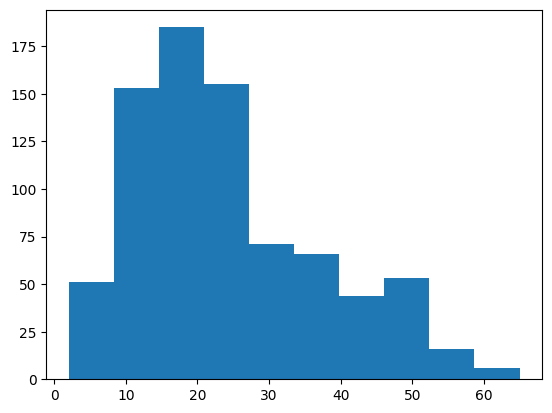

In [118]:
plt.hist([len(tokens) for tokens in train_X]);

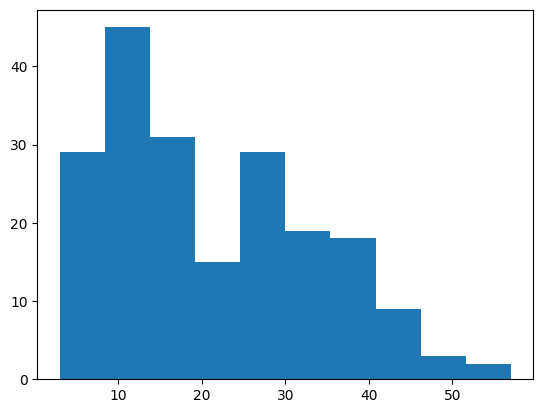

In [119]:
plt.hist([len(tokens) for tokens in test_X]);

In [120]:
maxlen = 40

In [121]:
train_X = sequence.pad_sequences(train_X, maxlen=maxlen)
test_X = sequence.pad_sequences(test_X, maxlen=maxlen)

In [122]:
train_X.shape, test_X.shape

((800, 40), (200, 40))

In [136]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [137]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [138]:
history = model.fit(train_X, train_y, validation_split=0.2, batch_size=64, epochs=5)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - f1_score: 0.2577 - loss: 1.0939 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.2089 - val_loss: 1.0577 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - f1_score: 0.2030 - loss: 1.0641 - precision: 0.4035 - recall: 0.0429 - val_f1_score: 0.3618 - val_loss: 1.0115 - val_precision: 0.6604 - val_recall: 0.2188
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - f1_score: 0.3883 - loss: 1.0290 - precision: 0.5650 - recall: 0.1436 - val_f1_score: 0.3786 - val_loss: 0.9880 - val_precision: 0.6237 - val_recall: 0.3625
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - f1_score: 0.4037 - loss: 0.9754 - precision: 0.6083 - recall: 0.3321 - val_f1_score: 0.3782 - val_loss: 0.9850 - val_precision: 0.6582 - val_recall: 0.3250
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - f1_score: 0.4255 - loss: 0.9016 - precision: 0.7124 - recall: 0.3335 - val_f1_score: 0.3907 - val_

In [139]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (64, 40, 32)                │         192,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (64, 40, 32)                │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (64, 20, 32)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (64, 64)                    │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (64, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 663,467 (2.53 MB)

 Trainable params: 221,155 (863.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 442,312 (1.69 MB)

<Axes: >

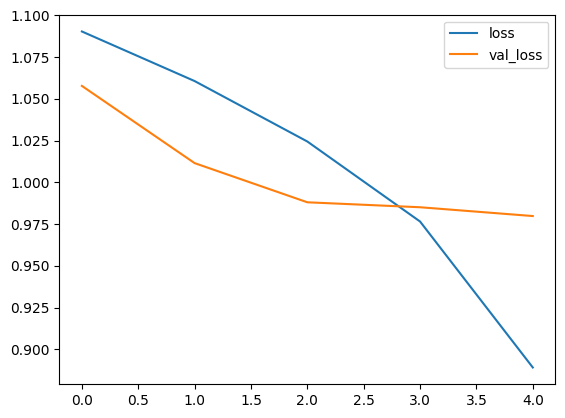

In [140]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [141]:
preds = model.predict(test_X)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


In [148]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
print(classification_report(test_y, preds))

In [ ]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")